In [1]:
import re
from typing import List, Optional, Tuple
import numpy as np

# ---------- Parse "(re,im)" tuples; one "Taps starting:" block = one OFDM symbol ----------
_PAIR = re.compile(
    r"\(\s*([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*,\s*"
    r"([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*\)"
)

def read_symbol_csi(
    path: str,
    section_headers=("Taps starting", "CSI starting"),
) -> List[np.ndarray]:
    frames: List[np.ndarray] = []
    cur: List[Tuple[float,float]] = []

    def flush():
        nonlocal cur
        if cur:
            frames.append(np.array([a + 1j*b for a,b in cur], dtype=np.complex64))
            cur = []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if any(h.lower() in s.lower() for h in section_headers):
                flush()
                continue
            m = _PAIR.search(s)
            if m:
                cur.append((float(m.group(1)), float(m.group(2))))
    flush()
    return frames  # list of complex64 arrays, one per OFDM symbol (length should be 64)

# ---------- Helpers ----------
def ofdm_Tsym(fs: float, nfft: int, cp_ratio: float) -> float:
    """OFDM symbol duration (incl. CP) in seconds."""
    Tu = nfft / fs
    return Tu * (1.0 + cp_ratio)

def remove_cpe(H: np.ndarray, used_bins: Optional[np.ndarray] = None) -> np.ndarray:
    if used_bins is None:
        used_bins = np.ones_like(H, dtype=bool)
    ph = np.angle(np.mean(H[used_bins]))
    return H * np.exp(-1j * ph)

# ---------- Resample symbol stream to exactly 1 kHz ----------
def resample_csi_to_1khz(
    symbols: List[np.ndarray],
    fs: float = 5e6,
    nfft: int = 64,
    cp_ratio: float = 1/8,
    do_cpe: bool = True,
    used_bins: Optional[np.ndarray] = None,
    amp_norm: Optional[str] = None,   # 'rms' | 'mean' | None
    fill: str = "zoh"                 # 'zoh' (hold) | 'nan'
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Input:
      symbols: list of complex CSI vectors (one per OFDM symbol).
    Output:
      times: shape [N_out], seconds
      csi_1k: shape [N_out, nfft] complex64, 1 kHz (Δt = 1 ms) rate
    """
    if not symbols:
        return np.zeros((0,), dtype=float), np.zeros((0,0), dtype=np.complex64)
    N = len(symbols[0])
    assert all(len(s) == N for s in symbols), "All symbols must have same length"
    Ts = ofdm_Tsym(fs, nfft, cp_ratio)             # ~14.4 us at 5 MHz, 64-pt, CP=1/8
    t_sym = np.arange(len(symbols), dtype=np.float64) * Ts  # assume contiguous symbols
    t0, t_end = t_sym[0], t_sym[-1] + Ts
    dt = 1e-3                                      # 1 ms
    times = np.arange(t0, t_end, dt, dtype=np.float64)
    out = np.empty((len(times), N), dtype=np.complex64)

    last = np.zeros(N, dtype=np.complex64)
    def _norm(v: np.ndarray) -> np.ndarray:
        if amp_norm is None: return v
        mask = used_bins if used_bins is not None else np.ones(N, dtype=bool)
        if amp_norm == "rms":
            s = np.sqrt(np.mean(np.abs(v[mask])**2))
        elif amp_norm == "mean":
            s = np.mean(np.abs(v[mask]))
        else:
            raise ValueError("amp_norm must be 'rms', 'mean', or None")
        return v if s == 0 else v / s

    # Preprocess each symbol once (CPE + optional amp norm)
    proc = []
    for H in symbols:
        x = H.astype(np.complex64, copy=True)
        if do_cpe:
            x = remove_cpe(x, used_bins=used_bins)
        x = _norm(x)
        proc.append(x)
    proc = np.stack(proc, axis=0)  # [Nsym, N]

    # Windowed average into 1 ms bins
    idx_start = 0
    for i, t in enumerate(times):
        t1 = t
        t2 = t + dt
        # symbols whose start time falls in [t1, t2)
        while idx_start < len(t_sym) and t_sym[idx_start] < t1:
            idx_start += 1
        idx_end = idx_start
        while idx_end < len(t_sym) and t_sym[idx_end] < t2:
            idx_end += 1

        if idx_end > idx_start:
            avg = proc[idx_start:idx_end].mean(axis=0)
            out[i] = avg
            last = avg
        else:
            if fill == "zoh":
                out[i] = last
            else:
                out[i] = np.nan + 1j*np.nan

    return times, out
import numpy as np
import pywt  # pip install PyWavelets

def _minimax_thresh(x):
    """
    Donoho–Johnstone minimax threshold:
    T = sigma * (0.3936 + 0.1829 * log2(n)), sigma from MAD of finest details.
    """
    n = x.size
    if n <= 1:
        return 0.0
    return (0.3936 + 0.1829 * np.log2(n))

def _wavelet_denoise_1d(x, wavelet="db4", level=4, thr_mode="soft"):
    """
    DWT -> threshold detail coeffs -> IDWT
    Matches the paper: Daubechies D4, 4 levels, adaptive minimax threshold. :contentReference[oaicite:1]{index=1}
    """
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level, mode="symmetric")
    cA, cD_list = coeffs[0], coeffs[1:]

    # noise sigma from level-1 details (finest scale)
    cD1 = cD_list[-1]  # last item is level-1 in PyWavelets order
    sigma = np.median(np.abs(cD1)) / 0.6745 if cD1.size else 0.0
    T = sigma * _minimax_thresh(x)

    # threshold all detail coeffs
    cD_thr = [pywt.threshold(cD, value=T, mode=thr_mode) for cD in cD_list]

    # reconstruct
    coeffs_thr = [cA] + cD_thr
    y = pywt.waverec(coeffs_thr, wavelet=wavelet, mode="symmetric")
    # match original length
    return y[: len(x)]

def denoise_csi(H, wavelet="db4", level=4, thr_mode="soft", apply_to="complex"):
    """
    Wavelet denoise CSI matrix H (T, S).
      apply_to: "complex" (default) -> denoise real & imag separately and recombine,
                 "magnitude"       -> denoise |H| and keep original phase,
                 "real"            -> denoise real only (imag unchanged)
    Returns H_denoised with same shape/dtype as H.
    """
    H = np.asarray(H)
    T, S = H.shape
    out = np.empty_like(H, dtype=np.complex128)

    if apply_to == "complex":
        for k in range(S):
            xr = _wavelet_denoise_1d(np.real(H[:, k]), wavelet, level, thr_mode)
            xi = _wavelet_denoise_1d(np.imag(H[:, k]), wavelet, level, thr_mode)
            out[:, k] = xr + 1j * xi

    elif apply_to == "magnitude":
        mag = np.abs(H); ph = np.angle(H)
        for k in range(S):
            mdk = _wavelet_denoise_1d(mag[:, k], wavelet, level, thr_mode)
            out[:, k] = mdk * np.exp(1j * ph[:, k])

    elif apply_to == "real":
        out[:] = H
        for k in range(S):
            xr = _wavelet_denoise_1d(np.real(H[:, k]), wavelet, level, thr_mode)
            out[:, k] = xr + 1j * np.imag(H[:, k])
    else:
        raise ValueError("apply_to must be 'complex', 'magnitude', or 'real'.")

    return out

# ---- Example usage for your resampled H_1k ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def minmax01(x, eps=1e-9):
    x = np.asarray(x, float)
    mn, mx = np.nanmin(x), np.nanmax(x)
    return (x - mn) / (mx - mn + eps)

def mask_to_segments(mask):
    m = mask.astype(np.int8)
    dm = np.diff(np.r_[0, m, 0])
    starts = np.where(dm == 1)[0]
    ends   = np.where(dm == -1)[0]
    return list(zip(starts, ends))  # [ (s,e), ... ), e exclusive

# ---------- main: variance-based selector ----------
def select_by_variance(
    df_two_cols: pd.DataFrame,
    fs: float = 1000.0,
    win_ms: int = 50,            # window length for variance (e.g., 30–80 ms)
    combine: str = "mean",       # "mean" or "max" across the two subcarriers
    hi: float = 0.60,            # hysteresis hi threshold on min-max score
    lo: float = 0.30,            # hysteresis lo threshold
    min_dur_ms: int = 150,       # drop segments shorter than this
    min_gap_ms: int = 80,        # merge segments separated by < this gap
    top_k: int = 3,              # keep top-K by energy
):
    # 1) rolling variance per column (centered)
    n = max(1, int(round(win_ms/1000.0 * fs)))
    n = n if n % 2 == 1 else n + 1  # odd window for symmetric centering

    v1 = df_two_cols.iloc[:,0].rolling(window=n, center=True).var(ddof=0).to_numpy()
    v2 = df_two_cols.iloc[:,1].rolling(window=n, center=True).var(ddof=0).to_numpy()
    v1[np.isnan(v1)] = 0.0
    v2[np.isnan(v2)] = 0.0

    # 2) combine channels
    if combine == "max":
        score = np.maximum(v1, v2)
    else:  # "mean"
        score = 0.5*(v1 + v2)

    # 3) normalize score to (0,1)
    s = minmax01(score)

    # 4) hysteresis thresholding
    active = np.zeros_like(s, dtype=bool)
    on = False
    for i, val in enumerate(s):
        if not on and val >= hi: on = True
        elif on and val <= lo:   on = False
        active[i] = on

    # 5) prune short, merge close
    segs = mask_to_segments(active)
    min_dur  = int(round(min_dur_ms/1000.0*fs))
    min_gap  = int(round(min_gap_ms/1000.0*fs))
    segs = [(a,b) for (a,b) in segs if (b-a) >= min_dur]

    merged = []
    for a,b in segs:
        if not merged:
            merged.append([a,b])
        else:
            pa,pb = merged[-1]
            if a - pb <= min_gap:
                merged[-1][1] = max(pb, b)
            else:
                merged.append([a,b])
    segs = [(a,b) for a,b in merged]

    # 6) rank by energy of s and keep top_k
    def energy(seg):
        a,b = seg
        v = s[a:b]
        return float(np.sum(v*v))
    segs_keep = sorted(segs, key=energy, reverse=True)[:top_k]
    indicator = len(segs_keep)

    return segs_keep, indicator, s

def get_cols(df, targets=("sc36","sc37"), idxs=(47,48)):
    if all(c in df.columns for c in targets):
        return df[list(targets)]
    for tcol in ("t","time","Time","timestamp"):
        if tcol in df.columns: df = df.drop(columns=[tcol])
    return df.iloc[:, list(idxs)]


def segments_to_tensor_same_len(data_s: pd.DataFrame, segs):
    """
    data_s: 2-col DataFrame (T,2)
    segs: list of (s, e) with e exclusive; lengths may differ
    Returns:
      tensor: (N, Lmax, 2)  -- all slices equal length
      idx_eq: (N,2)         -- adjusted indices [s, e) used
      Lmax: int             -- common length
    """
    X = data_s.to_numpy(dtype=float)  # (T,2)
    T = len(X)

    # sort and sanitize input indices
    segs = [tuple(map(int, se)) for se in segs]
    segs = sorted(segs, key=lambda se: (se[0], se[1]))

    # find the largest length
    lengths = [max(0, min(e, T) - max(0, min(s, T-1))) for (s, e) in segs]
    Lmax = int(max(lengths))
    if Lmax <= 0:
        raise ValueError("All segments are empty or out of bounds.")

    # extend each (s,e) to length Lmax by pushing e right; if it hits T, shift left
    idx_eq = []
    for (s, e) in segs:
        s = int(max(0, min(s, T-1)))
        # target end if we extend to Lmax
        e_target = s + Lmax
        if e_target <= T:
            s2, e2 = s, e_target
        else:
            # shift window left so it fits
            e2 = T
            s2 = max(0, T - Lmax)
        # final safety: ensure non-empty and exact length
        if e2 - s2 != Lmax:
            # this only happens if T < Lmax (shouldn't in normal use)
            Lmax = e2 - s2
        idx_eq.append((s2, e2))

    idx_eq = np.array(idx_eq, dtype=int)

    # slice and stack -> (N, Lmax, 2)
    tensor = np.stack([X[s:e] for (s, e) in idx_eq], axis=0)
    return tensor, idx_eq, Lmax







1 kHz CSI shape: (18840, 64)
selected: 10 segments: [(6449, 7229), (8243, 8993), (1127, 1845), (4849, 5460), (3012, 3719), (15604, 16225), (17350, 18247), (12027, 12629), (10202, 10802), (13794, 14362)]
[818, 807, 711, 880, 850, 700, 702, 668, 721, 997]
mean_len:  785.4
tensor_shape: (10, 997, 2)


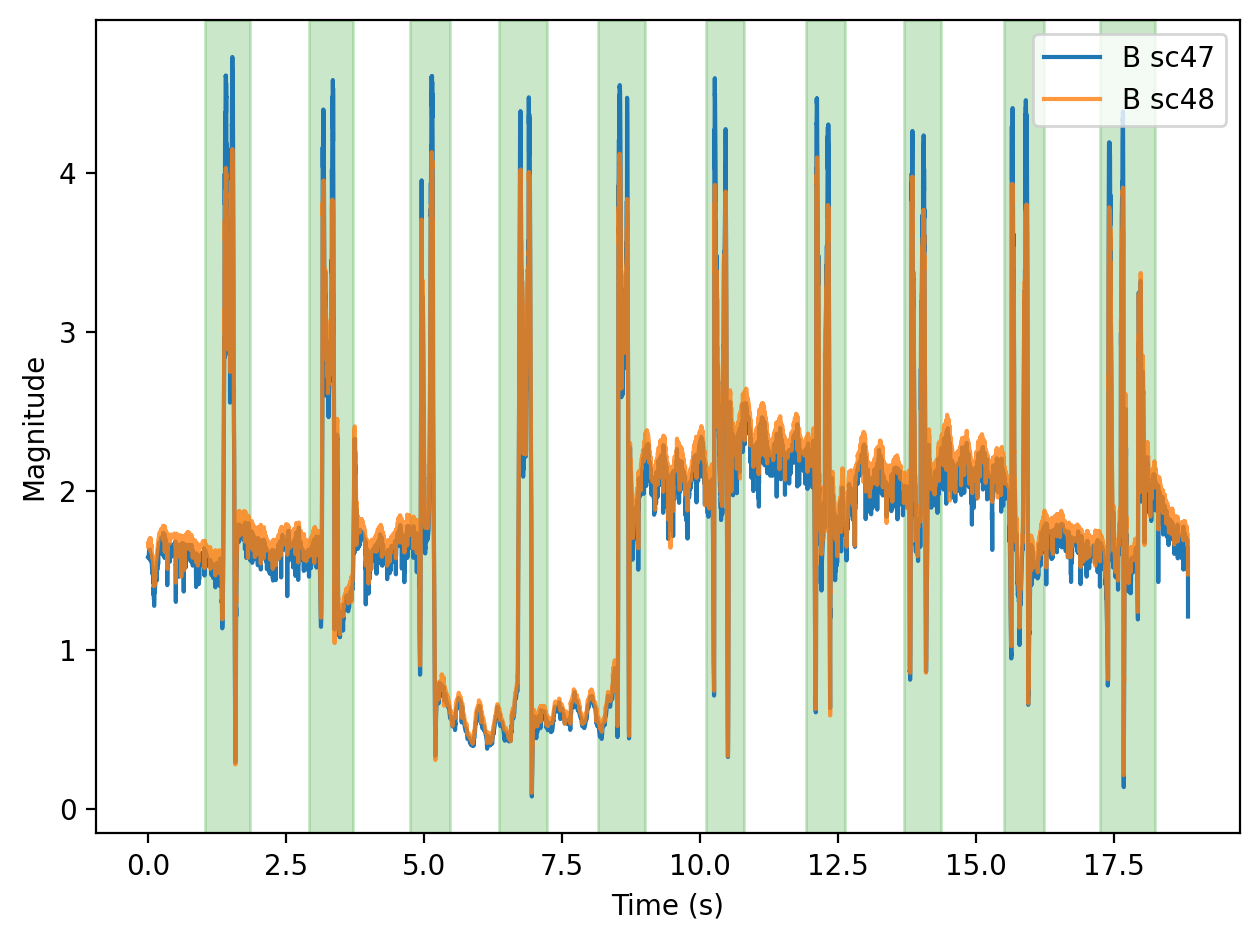

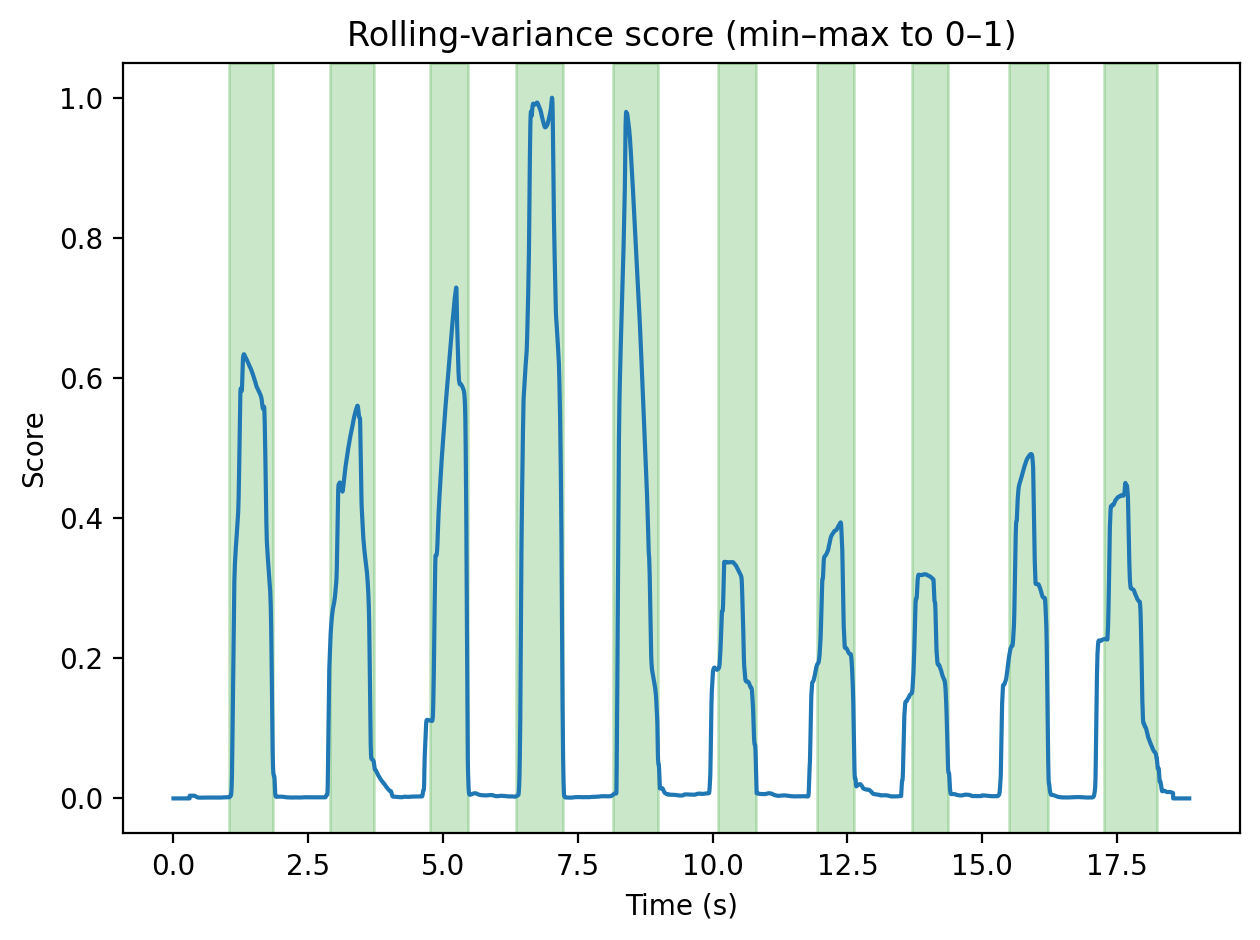

In [5]:

for date_num in ['']:
    date = f'9_29_{date_num}'
    # date = '9_29_E'
    # path = f"taps_num_34567.txt"   # your captured file
    path = 'taps_9_29_C_num_34567.txt'
    syms = read_symbol_csi(path)   # list of 64-bin complex vectors, one per OFDM symbol
    # If you have DC/guards, you can exclude them from CPE/normalization:
    used_mask = None


# used_mask = np.ones(64, dtype=bool); used_mask[32] = False  # example: drop DC bin

    t, H_1k = resample_csi_to_1khz(
        syms,
        fs=1e6, nfft=64, cp_ratio=1/4,
        do_cpe=True,
        used_bins=used_mask,
        amp_norm=None,     # or 'rms' for scale invariance
        fill="zoh"
    )
    print("1 kHz CSI shape:", H_1k.shape)   # (N_out, 64)
    # np.save(f"csi_1khz_{date}_num_0.npy", H_1k)      ##  averaging process
    # # # Optional exports for ML:
    # np.savetxt(f"csi_1khz_mag_{date}_num_0.csv", np.abs(H_1k), delimiter=",")
    # np.savetxt(f"csi_1khz_phase_{date}_num_0.csv", np.angle(H_1k), delimiter=",")
    # np.savetxt(f"csi_mag_{date}_num_0.csv", np.abs(syms), delimiter=",")
    # H_1k shape: (T, Nsc) complex
    T, N = H_1k.shape
    keep_idx = np.arange(N)[6:N-5]      # drop first 6, last 5
    H_1k_trim = H_1k[:, keep_idx]       # (T, N-11)
    # np.savetxt(f"csi_1khz_mag_{date}_num_0.csv", np.abs(H_1k_trim), delimiter=",")
    # H_1k shape: (T, S) complex; fs=1 kHz slow-time
    H_1k_trim_denoised = denoise_csi(H_1k_trim, wavelet="db4", level=4, thr_mode="soft", apply_to="complex")


    data_s = pd.DataFrame(np.abs(H_1k_trim_denoised[:, list((47, 48))]))
    segs, count, score = select_by_variance(data_s, fs=1000.0, win_ms=600, combine="max",
                                            hi=0.30, lo=0.05, min_dur_ms=300, min_gap_ms=100, top_k=12)
    print("selected:", count, "segments:", segs)

    # segs: [(s,e), ...]
    T = len(data_s)  # clip to valid range [0, T]

    expanded = []
    for s, e in segs:
        s2 = max(0, s - 100)
        e2 = e
        if e2 <= s2:                  # safety: ensure non-empty
            e2 = min(T, s2 + 1)
        expanded.append((s2, e2))
    segs = expanded    




    
    # TIME duration feature
    # sort and sanitize input indices
    segs = [tuple(map(int, se)) for se in segs]
    segs = sorted(segs, key=lambda se: (se[0], se[1]))

    # segs is a list of (s, e) tuples
    lengths = [e - s for (s, e) in segs]
    print(lengths)                 # list of lengths
    mean_len = sum(lengths) / len(lengths)
    print("mean_len: ", mean_len)
    

    ## use the new segs to store the selected signal 

    # --- usage ---
    # data_s = pd.DataFrame(np.abs(H_1k_trim_denoised[:, [47, 48]]))
    # segs = [(s1,e1), (s2,e2), ...]  # all same e-s
    tensor, idx_used, time_length = segments_to_tensor_same_len(data_s, segs)
    print("tensor_shape:", tensor.shape)  # -> (N, time_length, 2)

    


        # quick viz
    t = np.arange(len(data_s))/1000.0
    plt.figure(dpi=200)
    plt.plot(t, data_s.iloc[:,0], label="B sc47")
    plt.plot(t, data_s.iloc[:,1], label="B sc48", alpha=0.8)
    for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
    plt.legend(); plt.xlabel("Time (s)"); plt.ylabel("Magnitude"); plt.tight_layout(); plt.show()

    plt.figure(dpi=200)
    plt.plot(t, score); 
    for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
    plt.title("Rolling-variance score (min–max to 0–1)")
    plt.xlabel("Time (s)"); plt.ylabel("Score"); plt.tight_layout(); plt.show()
    ## 


In [8]:
date = "9_29_C"

In [9]:
## save the tensor

np.save(f"class_1_tensor_{date}.npy", tensor)          # saves only the tensor
np.save(f"class_1_idx_used_{date}.npy", idx_used)      # indices
# load with: tensor = np.load("tensor.npy")


In [10]:
import numpy as np
import pandas as pd

def segment_energy(data_2ch, idx_used, mode="energy", per_channel=False):
    """
    data_2ch : (T,2) array or DataFrame (e.g., magnitudes of sc47, sc48)
    idx_used : (N,2) array of [start, end) indices (what you saved as idx_used)
    mode     : "energy" -> sum |x|^2       (depends on segment length)
               "power"  -> mean(|x|^2)     (length-invariant)
    per_channel : if True, return energy per channel (N,2);
                  else return combined across channels (N,)

    Returns: energies, lengths
    """
    X = np.asarray(data_2ch, dtype=float)
    idx_used = np.asarray(idx_used, dtype=int)
    N = idx_used.shape[0]
    if per_channel:
        out = np.zeros((N, 2), dtype=float)
    else:
        out = np.zeros(N, dtype=float)
    lengths = np.zeros(N, dtype=int)

    for i, (s, e) in enumerate(idx_used):
        seg = X[s:e]           # (L,2)
        L = seg.shape[0]
        lengths[i] = L
        e2 = (seg ** 2)        # |x|^2 since input is magnitude
        if mode == "power":
            e2 = e2.mean(axis=0)   # per channel mean
        else:  # "energy"
            e2 = e2.sum(axis=0)    # per channel sum

        if per_channel:
            out[i] = e2
        else:
            out[i] = e2.sum()      # combine two channels

    return out, lengths

# ---------- Example usage ----------
# Load the indices you saved earlier:
idx_used_1 = np.load(f"class_1_idx_used_{date}.npy")   # shape (N1,2)
# idx_used_2 = np.load("class_2_idx_used.npy")   # etc.
# idx_used_3 = np.load("class_3_idx_used.npy")

# data_1, data_2, data_3 should be the original 2-column magnitude streams
# used to cut segments for each class (e.g., pd.DataFrame or np.ndarray of shape (T,2)).

# Compute total energy per segment (sum |x|^2 across time & channels):
E1, L1 = segment_energy(data_s, idx_used_1, mode="energy", per_channel=False)
# E2, L2 = segment_energy(data_2, idx_used_2, mode="energy", per_channel=False)
# E3, L3 = segment_energy(data_3, idx_used_3, mode="energy", per_channel=False)

print("Class1 energy:", E1)
# print("Class2 energy:", E2)
# print("Class3 energy:", E3)

# If you prefer length-invariant average power and per-channel breakdown:
P1_ch, _ = segment_energy(data_s, idx_used_1, mode="power", per_channel=True)  # (N1,2)

# Optional: convert to dB
E1_dB = 10*np.log10(np.maximum(E1, 1e-12))


Class1 energy: [ 9039.04934252  8631.51542016  5229.99798164  5070.86219477
  8175.9338085  11983.28223099  9757.50616565 10702.3131219
  8174.21806772  8966.93331414]


In [86]:
# segs like [(s1,e1), (s2,e2), ...] with e exclusive
idx = np.concatenate([np.arange(s, e) for (s, e) in segs])
rows = data_s.iloc[idx]          # all rows from the segments (stacked)

In [91]:
segments = [data_s.iloc[s:e].copy() for (s, e) in segs]  # list of DataFrames
# e.g., first segment: segments[0]
# all concatenated:
rows = pd.concat(segments, ignore_index=True)
rows.shape

(8854, 2)